# Data Import and Cleaning 

#### Datasets from here: 
- https://www.census.gov/programs-surveys/sipp/data/datasets/2008-panel/wave-1.html
- https://www.census.gov/programs-surveys/sipp/data/datasets/2008-panel/wave-2.html
#### Column definition from here: 
- https://www2.census.gov/programs-surveys/sipp/data/datasets/2008/l08puw1.sas
- https://www2.census.gov/programs-surveys/sipp/data/datasets/2008/p08putm1.sas

In [5]:
import numpy as np
import pandas as pd

In [183]:
# sas input statement needs to be cleaned by hand: remove all whitespaces and $-signs e.g. replace ' -' with '-'
# columns that should be kept, need to be defined by hand as well
def import_sipp_data(sas_input_statement, dat_file, columns_keep):
    input_dict = np.loadtxt(sas_input_statement, dtype = str)
    column_lst = input_dict[:, 0].tolist()
    
    colspecs = []
    for string in input_dict[:, 1]:
        tpl_temp = tuple(map(int, string.split('-')))
        tpl_temp = (tpl_temp[0]-1, tpl_temp[1]) # second number should also be corrected?
        colspecs.append(tpl_temp)
    df_raw = pd.read_fwf(dat_file, names=column_lst, colspecs=colspecs)

    df = df_raw[columns_keep]
    del df_raw
    return df

In [180]:
# columns core dataset
clmn_join = ['SSUID', 'SPANEL', 'SWAVE', 'TFIPSST', 'EOUTCOME', 'SHHADID', 'RFID', 'RFID2', 'EENTAID','EPPPNUM', 'EPOPSTAT', 'EPPINTVW', 'ESEX', 
            'ERACE', 'EORIGIN', 'WPFINWGT', 'ERRP', 'EMS', 'EPNMOM', 'EPNDAD', 'EPNGUARD', 'EPNSPOUS', 'RDESGPNT', 'TAGE', 'EEDUCATE']

clmn_general = ['SREFMON', 'EHREFPER', 'RHCALMN', 'RHCALYR', 'TMOVRFLG', 'EHHNUMPP', 'EFSPOUSE', 'RFNKIDS', 'EBORNUS', 'ECITIZEN', 'RENROLL']

# make hist for all income categories and combine the small ones into a new 'other' or substract all interesting income streams from total and take the residual.
clmn_income = ['TFEARN', 'TFTOTINC', 'TPEARN', 'TPTOTINC', 'THTRNINC', 'THOTHINC', 'ETENURE', 'THPNDIST', 'THSOCSEC', 'THVETS', 'THLUMPSM', 'THAFDC', 
                'EAST1C', 'THPRPINC', 'TINTINC', 'TDIVINC', 'EAST3B', 'EAST3C', 'EAST3D', 'EAST3E', 'EAST4A' ]
# moonlit
clmn_labor = ['EPAYHR1', 'EPAYHR2', 'TPYRATE1', 'TPYRATE2', 'EJBHRS1', 'EJBHRS2', 'EUNION1', 'EUNION2', 'TMLMSUM', 'EDISABL', 'EDISPREV', 
                'EAWOP', 'EABRE', 'ERSNOWRK', 'EPTRESN', 'EBUSCNTR', 'EJOBCNTR', 'RMWKSAB', 'EPDJBTHN', 'ELKWRK', 'ELAYOFF', 'EHRSALL', 'RMHRSWK', 'EPTWRK', 
                'RMESR', 'RMWKWJB', 'RWKSPERM', 'EBNO1', 'EBNO2']

columns_core = clmn_join + clmn_general + clmn_income + clmn_labor
print('length core columns: ', len(columns_core))

# columns topical dataset
clmn_join

clmn_rebate = ['EREBATE', 'ERBAMTH', 'ERBATAMT', 'ERBATTYP', 'EREBATOC']

columns_topical = clmn_join + clmn_rebate
print('length topical columns: ', len(columns_topical))

length core columns:  86
length topical columns:  30


### Import SIPP data

In [18]:
w1_core = import_sipp_data('input_core.txt', '/Users/maxweber/Desktop/DataMasterThesis/l08puw1.dat', columns_core)
print('w1 core imported')
w1_core.to_csv('/Users/maxweber/Desktop/DataMasterThesis/core_w1.csv') 
print('w1 core exported to csv')

w2_core = import_sipp_data('input_core.txt', '/Users/maxweber/Desktop/DataMasterThesis/l08puw2.dat', columns_core)
print('w2 core imported')
w2_core.to_csv('/Users/maxweber/Desktop/DataMasterThesis/core_w2.csv') 
print('w2 core exported to csv')

w1 core imported
w1 core exported to csv
w2 core imported
w2 core exported to csv


In [185]:
w1_topical = import_sipp_data('input_topical_w1.txt', '/Users/maxweber/Desktop/DataMasterThesis/p08putm1.dat', columns_topical)
print('w1 topical imported')
w1_topical.to_csv('/Users/maxweber/Desktop/DataMasterThesis/topical_w1.csv') 
print('w1 topical exported to csv')

w2_topical = import_sipp_data('input_topical_w2.txt', '/Users/maxweber/Desktop/DataMasterThesis/p08putm2.dat', columns_topical)
print('w2 topical imported')
w2_topical.to_csv('/Users/maxweber/Desktop/DataMasterThesis/topical_w2.csv') 
print('w2 topical exported to csv')

w1 topical imported
w1 topical exported to csv
w2 topical imported
w2 topical exported to csv


In [59]:
print(w1_core.shape)
print(w1_topical.shape)
w1_full = w1_core.merge(w1_topical, how = 'left', on = clmn_join)
w1_full.shape

(421911, 86)
(105663, 30)


(421911, 91)

In [61]:
print(w2_core.shape)
print(w2_topical.shape)
w2_full = w2_core.merge(w2_topical, how = 'left', on = clmn_join)
w2_full.shape

(392702, 86)
(98504, 30)


(392702, 91)

In [69]:
df = pd.concat([w1_full, w2_full])
df.to_csv('/Users/maxweber/Desktop/DataMasterThesis/full_sipp.csv') 
print(df.shape)
df.head()
del [w1_core, w2_core, w1_topical, w2_topical]

(814613, 91)


In [133]:
df = pd.read_csv('/Users/maxweber/Desktop/DataMasterThesis/full_sipp.csv')
df.drop('Unnamed: 0', axis = 1, inplace=True)
df.shape

(814613, 91)

# ToDo: 

- compare to houshold dataframe and individual dataframe
- implement the cleaning steps from the other notebook

In [146]:
df[clmn_rebate].describe()

# why is max ERBAMTH 9 and in the houshold datafram its 12?

,EREBATE,ERBAMTH,ERBATAMT,ERBATTYP,EREBATOC
count,204167.000000,204167.000000,204167.000000,204167.000000,204167.000000
mean,0.749465,3.459844,248.793943,1.231232,1.621472
std,0.433322,2.578473,287.948038,0.421622,0.878008
min,0.000000,0.000000,0.000000,1.000000,1.000000
25%,0.000000,1.000000,0.000000,1.000000,1.000000
50%,1.000000,4.000000,50.000000,1.000000,1.000000
75%,1.000000,6.000000,600.000000,1.000000,3.000000
max,1.000000,9.000000,998.000000,2.000000,3.000000


In [74]:
df[clmn_join].describe()

,SSUID,SPANEL,SWAVE,TFIPSST,EOUTCOME,SHHADID,RFID,RFID2,EENTAID,EPPPNUM,...,WPFINWGT,ERRP,EMS,EPNMOM,EPNDAD,EPNGUARD,EPNSPOUS,RDESGPNT,TAGE,EEDUCATE
count,8.146130e+05,814613.0,814613.000000,814613.000000,814613.000000,814613.000000,814613.000000,814613.000000,814613.000000,814613.000000,...,8.146130e+05,814613.000000,0.0,814613.000000,814613.000000,814613.000000,814613.000000,814613.000000,814613.000000,814613.000000
mean,5.163185e+10,8.0,1.482072,5.086565,1.737015,11.118716,2.876340,2.772109,11.020911,103.011426,...,2.944598e+07,2.753835,NaN,713.649815,784.098297,33.574210,633.898105,1.517082,4.373987,3.875991
std,2.958629e+10,0.0,0.499679,2.568134,5.178684,1.085508,1.770319,1.719884,0.458779,9.126882,...,1.157673e+07,1.574532,NaN,417.792524,382.859258,79.234875,440.739942,0.499708,2.858257,3.204500
min,3.051038e+09,8.0,1.000000,0.000000,1.000000,11.000000,1.000000,1.000000,11.000000,101.000000,...,0.000000e+00,0.000000,NaN,101.000000,101.000000,1.000000,101.000000,1.000000,0.000000,0.000000
25%,2.434494e+10,8.0,1.000000,3.000000,1.000000,11.000000,2.000000,1.000000,11.000000,101.000000,...,2.062580e+07,1.000000,NaN,102.000000,999.000000,1.000000,102.000000,1.000000,2.000000,1.000000
50%,5.592512e+10,8.0,1.000000,6.000000,1.000000,11.000000,3.000000,3.000000,11.000000,102.000000,...,2.831825e+07,3.000000,NaN,999.000000,999.000000,1.000000,999.000000,2.000000,4.000000,4.000000
75%,7.792598e+10,8.0,2.000000,7.000000,1.000000,11.000000,4.000000,4.000000,11.000000,103.000000,...,3.646230e+07,4.000000,NaN,999.000000,999.000000,101.000000,999.000000,2.000000,7.000000,6.000000
max,9.795894e+10,8.0,2.000000,9.000000,71.000000,23.000000,32.000000,32.000000,22.000000,208.000000,...,2.329601e+08,9.000000,NaN,999.000000,999.000000,999.000000,999.000000,2.000000,9.000000,9.000000


In [75]:
df[clmn_general].describe()

,SREFMON,EHREFPER,RHCALMN,RHCALYR,TMOVRFLG,EHHNUMPP,EFSPOUSE,RFNKIDS,EBORNUS,ECITIZEN,RENROLL
count,0.0,814613.000000,814613.000000,814613.000000,814613.000000,814613.000000,814613.000000,814613.000000,814613.000000,814613.000000,814613.000000
mean,NaN,101.404041,4.078024,8.181521,0.488857,3.386554,435.923831,1.128416,1.122767,1.063391,2.373160
std,NaN,5.296237,3.326668,0.385449,0.546188,1.758453,433.381419,1.366720,0.328170,0.243665,0.914215
min,NaN,0.000000,0.000000,8.000000,0.000000,1.000000,101.000000,0.000000,1.000000,1.000000,1.000000
25%,NaN,101.000000,1.000000,8.000000,0.000000,2.000000,102.000000,0.000000,1.000000,1.000000,1.000000
50%,NaN,101.000000,2.000000,8.000000,0.000000,3.000000,102.000000,1.000000,1.000000,1.000000,3.000000
75%,NaN,101.000000,8.000000,8.000000,1.000000,4.000000,999.000000,2.000000,1.000000,1.000000,3.000000
max,NaN,205.000000,9.000000,9.000000,6.000000,22.000000,999.000000,9.000000,2.000000,2.000000,3.000000


In [76]:
df[clmn_income].describe()

,TFEARN,TFTOTINC,TPEARN,TPTOTINC,THTRNINC,THOTHINC,ETENURE,THPNDIST,THSOCSEC,THVETS,...,THAFDC,EAST1C,THPRPINC,TINTINC,TDIVINC,EAST3B,EAST3C,EAST3D,EAST3E,EAST4A
count,814613.000000,814613.000000,814613.000000,814613.000000,814613.000000,814613.000000,0.0,814613.000000,814613.000000,814613.000000,...,814613.000000,814613.000000,814613.000000,814613.000000,814613.000000,814613.000000,814613.000000,814613.000000,814613.000000,814613.000000
mean,4790.451940,5635.295581,1662.946589,2055.775417,56.825505,706.452685,NaN,32.863291,329.498753,21.444310,...,9.310745,1.569069,132.286837,18.064701,13.394549,1.680221,1.778079,1.783732,1.785763,1.752842
std,5869.432422,5858.342678,3321.260748,3386.315237,246.020981,1351.857000,NaN,523.908785,685.252650,193.586169,...,72.843727,0.495207,708.826348,108.709187,111.891769,0.466391,0.415539,0.411700,0.410292,0.431360
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,0.000000,0.000000,0.000000,...,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,784.000000,2019.000000,0.000000,0.000000,0.000000,0.000000,NaN,0.000000,0.000000,0.000000,...,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,2.000000,2.000000,2.000000,2.000000
50%,3304.000000,4153.000000,0.000000,1009.000000,0.000000,0.000000,NaN,0.000000,0.000000,0.000000,...,0.000000,2.000000,2.000000,0.000000,0.000000,2.000000,2.000000,2.000000,2.000000,2.000000
75%,6697.000000,7391.000000,2382.000000,2853.000000,0.000000,951.000000,NaN,0.000000,0.000000,0.000000,...,0.000000,2.000000,22.000000,2.000000,0.000000,2.000000,2.000000,2.000000,2.000000,2.000000
max,98083.000000,101970.000000,96244.000000,96447.000000,6287.000000,45012.000000,NaN,62000.000000,18543.000000,10000.000000,...,1586.000000,2.000000,36774.000000,5637.000000,5100.000000,2.000000,2.000000,2.000000,2.000000,2.000000


In [77]:
df[clmn_labor].describe()

,EPAYHR1,EPAYHR2,TPYRATE1,TPYRATE2,EJBHRS1,EJBHRS2,EUNION1,EUNION2,TMLMSUM,EDISABL,...,ELKWRK,ELAYOFF,EHRSALL,RMHRSWK,EPTWRK,RMESR,RMWKWJB,RWKSPERM,EBNO1,EBNO2
count,814613.000000,814613.000000,814613.000000,814613.000000,814613.000000,814613.000000,814613.000000,814613.000000,814613.000000,814613.000000,...,814613.000000,814613.000000,814613.000000,814613.000000,814613.000000,814613.000000,814613.000000,814613.000000,814613.000000,814613.000000
mean,1.187612,1.011086,125.504208,13.273585,1.571166,1.086220,1.384241,1.034587,6.929915,1.610629,...,1.133085,1.173857,1.320202,0.880578,1.315795,3.193426,2.264451,3.641039,1.001095,1.005144
std,0.390402,0.104706,266.165249,96.291735,2.192151,0.771989,0.486416,0.182731,142.217272,0.487608,...,0.339667,0.378987,1.844418,0.945555,0.464832,3.153751,2.016153,1.424765,0.036597,0.075215
min,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,1.000000,...,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000
25%,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,1.000000,...,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,4.000000,1.000000,1.000000
50%,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,2.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,4.000000,1.000000,1.000000
75%,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,2.000000,1.000000,0.000000,2.000000,...,1.000000,1.000000,1.000000,1.000000,2.000000,8.000000,4.000000,5.000000,1.000000,1.000000
max,2.000000,2.000000,999.000000,999.000000,9.000000,9.000000,2.000000,2.000000,9200.000000,2.000000,...,2.000000,2.000000,9.000000,6.000000,2.000000,8.000000,5.000000,5.000000,4.000000,5.000000


In [134]:
df[(df['SSUID'] == 19128000276) & (df['EPPPNUM'] == 101)]
# -> topical modul joined only once per wave

,SSUID,SPANEL,SWAVE,TFIPSST,EOUTCOME,SHHADID,RFID,RFID2,EENTAID,EPPPNUM,...,RMESR,RMWKWJB,RWKSPERM,EBNO1,EBNO2,EREBATE,ERBAMTH,ERBATAMT,ERBATTYP,EREBATOC
0,19128000276,8,1,2,1,11,1,1,11,101,...,8,0,4,1,1,NaN,NaN,NaN,NaN,NaN
1,19128000276,8,1,2,1,11,2,2,11,101,...,8,0,5,1,1,NaN,NaN,NaN,NaN,NaN
2,19128000276,8,1,2,1,11,3,3,11,101,...,8,0,4,1,1,NaN,NaN,NaN,NaN,NaN
3,19128000276,8,1,2,1,11,4,4,11,101,...,7,0,4,1,1,2.0,1.0,0.0,1.0,1.0
421911,19128000276,8,2,2,1,11,1,1,11,101,...,8,0,5,1,1,NaN,NaN,NaN,NaN,NaN
421912,19128000276,8,2,2,1,11,2,2,11,101,...,8,0,4,1,1,NaN,NaN,NaN,NaN,NaN
421913,19128000276,8,2,2,1,11,3,3,11,101,...,8,0,5,1,1,NaN,NaN,NaN,NaN,NaN
421914,19128000276,8,2,2,1,11,4,4,11,101,...,8,0,4,1,1,2.0,1.0,0.0,1.0,1.0


In [139]:
df['EREBATE'].replace(2, 0, inplace = True)
df['EREBATE'].isna().sum() # 610446 - is the topical module joined only to one row or are indeed 610k houshold nan in rebate?

print(df[df['EREBATE'] == 0]['ERBAMTH'].unique())
print(df[df['EREBATE'] == 0]['ERBATTYP'].unique())
print(df[df['EREBATE'] == 0]['EREBATOC'].unique())

[1.]
[1.]
[1.]


In [151]:
# if erebate = 0 -> ERBAMTH, ERBATTYP and EREBATOC need to be nan
def clean_norebate(erebate, clmn_to_nan):
    if erebate == 0:
       return np.NaN
    else:
        return clmn_to_nan

df['ERBAMTH'] = df.apply(lambda x: clean_norebate(x['EREBATE'], x['ERBAMTH']),axis=1)
df['ERBATTYP'] = df.apply(lambda x: clean_norebate(x['EREBATE'], x['ERBATTYP']),axis=1)
df['EREBATOC'] = df.apply(lambda x: clean_norebate(x['EREBATE'], x['EREBATOC']),axis=1)

print(df['ERBAMTH'].unique())
print(df['ERBATTYP'].unique())
print(df['EREBATOC'].unique())

[nan  1.  4.  5.  6.  7.  8.  9.  0.  2.]
[nan  1.  2.]
[nan  1.  2.  3.]


array([nan,  1.,  4.,  5.,  6.,  7.,  8.,  9.,  0.,  2.])

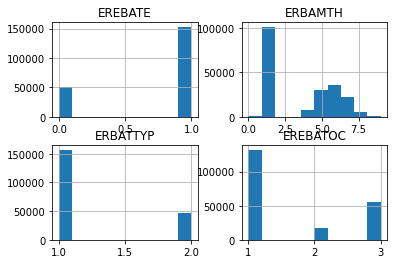

In [150]:
df[['EREBATE','ERBAMTH', 'ERBATTYP', 'EREBATOC']].hist()
df['ERBAMTH'].unique()

In [162]:
df['pp'] = df.groupby(['SSUID','EPPPNUM']).ngroup()
print(df['pp'].unique) #26569 unique
pp_count = df.groupby(['pp']).size()

df = df.merge(pp_count.rename('pp_count'), how = 'outer', left_on = 'pp', right_index = True)
df = df[df['pp_count']== 8]

print(len(df['pp'].unique())) #  N = 22998 as in figure 1 (results) Powell(2020) (dropped ~4k)
df.shape # 716.368 from 814.613 before

<bound method Series.unique of 0         23256
1         23256
2         23256
3         23256
4         23257
          ...  
814608    56812
814609    56813
814610    56813
814611    56813
814612    56813
Name: pp, Length: 814613, dtype: int64>
95171


(761368, 93)

In [170]:
len(df['pp'].unique()) # 4x more than in Paper dataset

95171

In [172]:
df['TAGE'].unique()

array([9, 2, 6, 7, 3, 0, 1, 5, 4, 8])

## Open Questions

- why is the max rebmonth = 9 (houshold data its 12)
- leading zeros are gone since not string type
- 75% instead of 81% rebated -> changes after grouping for HHs?


## ToDo
- subset on TAGE (18-65?) like Powell
- combine RHCALYR and RHCALMN as in the other notebook 

In [173]:
df.columns

Index(['SSUID', 'SPANEL', 'SWAVE', 'TFIPSST', 'EOUTCOME', 'SHHADID', 'RFID',
       'RFID2', 'EENTAID', 'EPPPNUM', 'EPOPSTAT', 'EPPINTVW', 'ESEX', 'ERACE',
       'EORIGIN', 'WPFINWGT', 'ERRP', 'EMS', 'EPNMOM', 'EPNDAD', 'EPNGUARD',
       'EPNSPOUS', 'RDESGPNT', 'TAGE', 'EEDUCATE', 'SREFMON', 'EHREFPER',
       'RHCALMN', 'RHCALYR', 'TMOVRFLG', 'EHHNUMPP', 'EFSPOUSE', 'RFNKIDS',
       'EBORNUS', 'ECITIZEN', 'RENROLL', 'TFEARN', 'TFTOTINC', 'TPEARN',
       'TPTOTINC', 'THTRNINC', 'THOTHINC', 'ETENURE', 'THPNDIST', 'THSOCSEC',
       'THVETS', 'THLUMPSM', 'THAFDC', 'EAST1C', 'THPRPINC', 'TINTINC',
       'TDIVINC', 'EAST3B', 'EAST3C', 'EAST3D', 'EAST3E', 'EAST4A', 'EPAYHR1',
       'EPAYHR2', 'TPYRATE1', 'TPYRATE2', 'EJBHRS1', 'EJBHRS2', 'EUNION1',
       'EUNION2', 'TMLMSUM', 'EDISABL', 'EDISPREV', 'EAWOP', 'EABRE',
       'ERSNOWRK', 'EPTRESN', 'EBUSCNTR', 'EJOBCNTR', 'RMWKSAB', 'EPDJBTHN',
       'ELKWRK', 'ELAYOFF', 'EHRSALL', 'RMHRSWK', 'EPTWRK', 'RMESR', 'RMWKWJB',
       'RWKSP

In [175]:
df[['SSUID', 'SPANEL', 'SWAVE', 'TFIPSST', 'EOUTCOME', 'SHHADID']]


array([2, 3, 0, 7, 9, 8, 1, 4, 6, 5])